In [1]:
!pip install transformers
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import random
random.seed(10)
from sklearn.model_selection import train_test_split
import re
from hazm import Normalizer, word_tokenize,Stemmer
from hazm import stopwords_list, word_tokenize
from nltk.stem import PorterStemmer

In [3]:
def preprocess(data):
  normalizer = Normalizer()
  stemmer = PorterStemmer()
  emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
  for i in range(len(data)):
    text=data[i]
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords_list()]
    filtered_text = ' '.join(filtered_tokens)
    for emoji in emojis.keys():
      filtered_text = filtered_text.replace(emoji, "EMOJI" + emojis[emoji])   
    filtered_text = filtered_text.replace("\u200c", "")
    data[i]=normalizer.normalize(filtered_text)
  return data

In [4]:
dftrain=pd.read_excel("/content/sentipers.xlsx")
dftest=pd.read_csv("/content/snapfood_testset.csv")

In [4]:
dftrain=pd.read_excel("/content/sentipers.xlsx")
dftest=pd.read_csv("/content/snapfood_testset.csv")
dftrain["text"]=preprocess(dftrain["text"])
dftest["comment"]=preprocess(dftest["comment"])

In [5]:
import numpy as np
import hazm
dftrain = dftrain.rename(columns={'polarity': 'label'})
dftrain['label'] = dftrain['label'].replace({'very bad': 0, 'bad': 1, 'neutral': 2, 'good': 3, 'very good': 4})
dftest['label'] = dftest['label'].replace({'SAD': 0, 'HAPPY': 1})

In [6]:
train_data, remaining_data = train_test_split(dftrain, train_size=0.8, random_state=10)
val_data, test_data = train_test_split(remaining_data, train_size=0.5, random_state=10)

<Axes: xlabel='label', ylabel='count'>

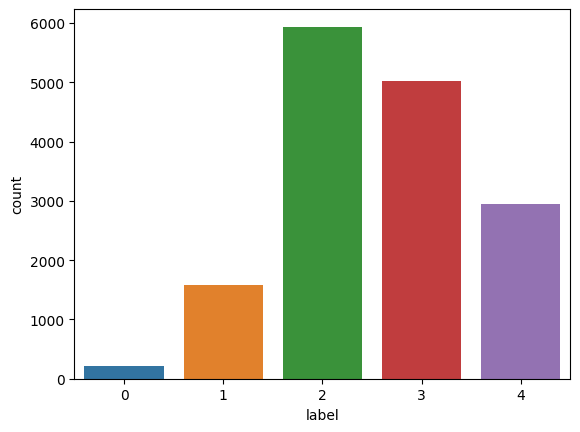

In [14]:
import seaborn as sns
sns.countplot(x=dftrain["label"])

<Axes: xlabel='label', ylabel='count'>

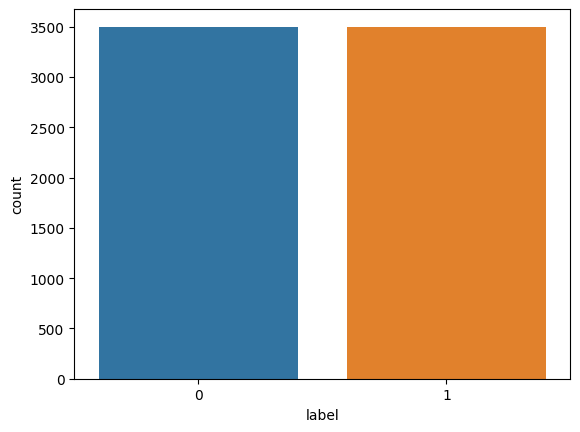

In [13]:
import seaborn as sns
sns.countplot(x=dftest["label"])

# Classes

In [7]:
import os
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer


def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [8]:
from torch.utils.data import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
class BertDataset(Dataset):
    def __init__(self, tokenizer,max_length,df):
        super(BertDataset, self).__init__()
        self.train_csv=df
        self.tokenizer=tokenizer
        self.labels=self.train_csv['label'].values
        self.max_length=max_length
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.labels[index], dtype=torch.long)
            }

model_name = "sentence-transformers/LaBSE"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

traindataset = BertDataset(tokenizer, max_length=100,df=train_data)
trainloader =DataLoader(dataset=traindataset,batch_size=16)

testdataset = BertDataset(tokenizer, max_length=100,df=test_data)
testloader =DataLoader(dataset=testdataset,batch_size=16)


valdataset = BertDataset(tokenizer, max_length=100,df=val_data)
valloader =DataLoader(dataset=valdataset,batch_size=16)

In [10]:
class Finetuned_bert(nn.Module):
    def __init__(self, hidden_size, num_classes,config_layer,freeze):
        super(Finetuned_bert, self).__init__()
        self.model = AutoModel.from_pretrained("sentence-transformers/LaBSE",config = config_layer)
        self.model=self.model.to(device)
        self.config=config_layer
        if freeze:
          for param in self.model.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(hidden_size, num_classes)
        #self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self,ids,mask,token_type_ids):
        _,o2= self.model(ids,attention_mask=mask, return_dict=False)
        o2 = self.fc1(o2)
        #o2 = self.relu(o2)
        #logits = self.fc2(o2)
        return o2

In [11]:
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
def train(train_loader,val_loader,model,epochs,learning_rate,gamma,step_size,device):

  model = model.to(device)
  history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
  # loss function
  criterion = nn.CrossEntropyLoss()

  # optimzier
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

  for epoch in tqdm(range(1, epochs + 1)):
    top1_acc_train = AverageMeter()
    loss_avg_train = AverageMeter()
    top1_acc_val = AverageMeter()
    loss_avg_val = AverageMeter()

    model.train()
    mode = "train"
    temp1=0
    temp2=0
    counter=0
    loop_train = tqdm(
        enumerate(train_loader, 1),
        total=len(train_loader),
        desc="train",
        position=0,
        leave=True)
    for batch, dl in loop_train:
      ids=dl['ids']
      token_type_ids=dl['token_type_ids']
      mask= dl['mask']
      labels=dl['target']

      ids=ids.to(device)
      token_type_ids=token_type_ids.to(device)
      mask=mask.to(device)
      labels=labels.to(device)

      labels_pred=model(
          ids=ids,
          mask=mask,
          token_type_ids=token_type_ids)

      loss = criterion(labels_pred, labels.squeeze())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      acc1 = accuracy(labels_pred,labels.squeeze() )
      top1_acc_train.update(acc1[0], ids.size(0))
      loss_avg_train.update(loss.item(), ids.size(0))
      loop_train.set_description(f"Train - iteration : {epoch}")
      counter=counter+1
      temp1=temp1+loss_avg_train.avg
      temp2=temp2+top1_acc_train.avg
      loop_train.set_postfix(
          loss_batch="{:.4f}".format(loss.detach().item()),
          avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
          top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
          max_len=2,
          refresh=True,)

    history["train_loss"].append(temp1/counter)
    history["train_acc"].append(temp2/counter)
    model.eval()
    mode = "val"
    counter=0
    temp1=0
    temp2=0
    with torch.no_grad():
      loop_val = tqdm(enumerate(val_loader, 1),total=len(val_loader),
                      desc="val",position=0,leave=True,)
      for batch, dl in loop_val:
        ids=dl['ids']
        token_type_ids=dl['token_type_ids']
        mask= dl['mask']
        labels=dl['target']

        ids=ids.to(device)
        token_type_ids=token_type_ids.to(device)
        mask=mask.to(device)
        labels=labels.to(device)

        labels_pred=model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids)
        loss = criterion(labels_pred, labels)
        acc1 = accuracy(labels_pred,labels )
        top1_acc_val.update(acc1[0], ids.size(0))
        loss_avg_val.update(loss.item(), ids.size(0))
        temp1=loss_avg_val.avg+temp1
        temp2=top1_acc_val.avg+temp2
        counter=counter+1
        loop_val.set_description(f"val - iteration : {epoch}")
        loop_val.set_postfix(
            loss_batch="{:.4f}".format(loss.detach().item()),
            avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
            top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
            refresh=True,)
    history["val_loss"].append(temp1/counter)
    history["val_acc"].append(temp2/counter)
    history["epochs"].append(epoch)        
    lr_scheduler.step()
  return model, history

# Training


In [12]:
config_layer = AutoConfig.from_pretrained("sentence-transformers/LaBSE")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier=Finetuned_bert(768,5,config_layer,False)

In [13]:
batch_size = 16
epochs = 1
learning_rate = 0.0001
gamma=0.5
step_size=10
model,history = train(train_loader=trainloader,val_loader=valloader,model = classifier,epochs=epochs,
                learning_rate=learning_rate,gamma = gamma,step_size = step_size,device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

train:   0%|          | 0/785 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


val:   0%|          | 0/98 [00:00<?, ?it/s]

In [25]:
torch.cuda.empty_cache()

In [14]:
import matplotlib.pyplot as plt
def plot_performance(history,name="Model"):
  figure, axis = plt.subplots(1, 2,figsize=(15,10))
  figure.suptitle('{} performance'.format(name), fontsize=16)
  axis[0].plot(history['epochs'],history['val_loss'])
  axis[0].plot(history['epochs'],history['train_loss'])
  axis[0].set_xticks(range(epochs))
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].set_title("Loss")
  axis[1].plot(history['epochs'],history['val_acc'])
  axis[1].plot(history['epochs'],history['train_acc'])
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].set_title("Accuracy")
  axis[1].set_xticks(range(epochs))
  figure.legend(["Val", "Train"], loc='upper right')
  figure.tight_layout(pad=5.0)
  return axis

array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Accuracy'>,
       <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Loss'>],
      dtype=object)

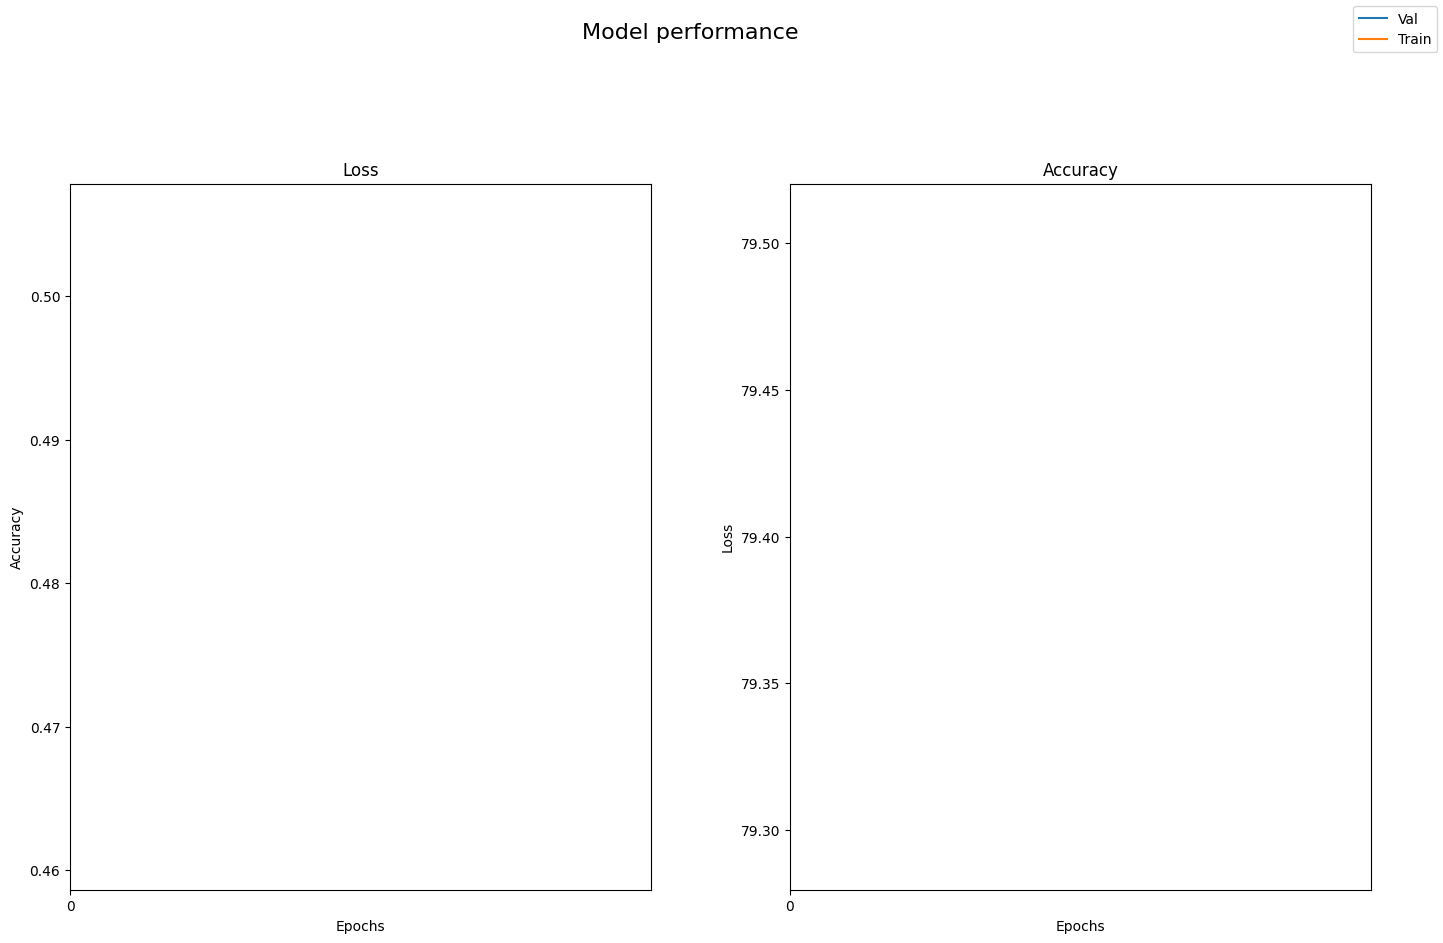

In [ ]:
plot_performance(history)

In [14]:
from sklearn.metrics import confusion_matrix
def predict(testloader,model):
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    loop_val = tqdm(enumerate(testloader, 1),total=len(testloader),
                    desc="val",position=0,leave=True,)
    for batch, dl in loop_val:
      ids=dl['ids']
      token_type_ids=dl['token_type_ids']
      mask= dl['mask']
      labels=dl['target']

      ids=ids.to(device)
      token_type_ids=token_type_ids.to(device)
      mask=mask.to(device)
      labels=labels.to(device)

      labels_pred=model(
          ids=ids,
          mask=mask,
          token_type_ids=token_type_ids)
      _, predicted = torch.max(labels_pred, 1)

      # Append predicted labels and true labels to the lists
      all_predictions.extend(predicted.tolist())
      all_targets.extend(labels.tolist())
  return all_predictions,all_targets

val:   0%|          | 0/785 [00:00<?, ?it/s]

val:   0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


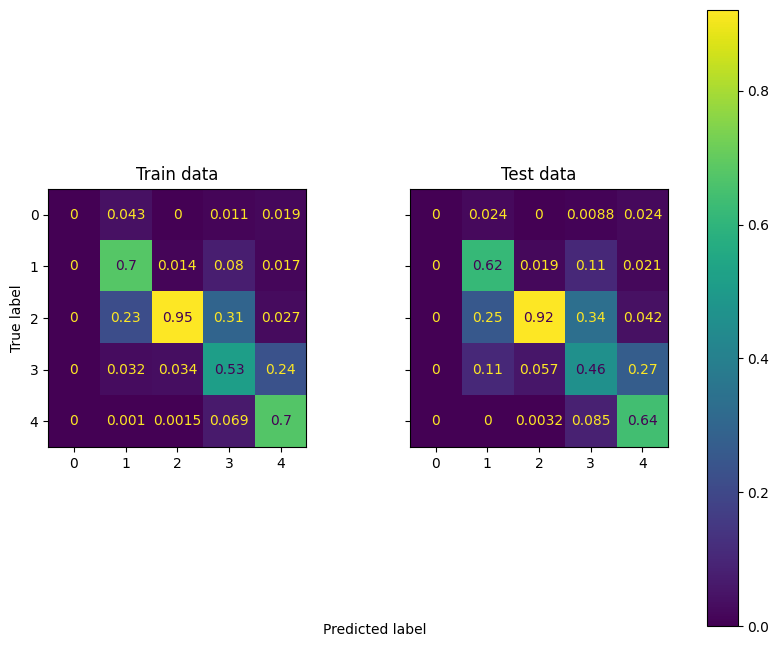

In [15]:
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, clf, tt in zip([0,1],
    ["Train data", "Test data"],
    [trainloader,testloader] ):
    y_pred,y_test=predict(tt,model)
    result = confusion_matrix(y_test, y_pred , normalize='pred' )
    disp = ConfusionMatrixDisplay(confusion_matrix=result)
    disp.plot(ax= axarr[idx])
    disp.ax_.set_title(clf)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
f.colorbar(disp.im_, ax=axarr)
plt.show()

In [16]:
from sklearn.metrics import classification_report
all_targets, all_predictions=predict(testloader,model)
print("The model classification report on test data is as followed:")
print(classification_report(all_targets, all_predictions))

all_targets, all_predictions=predict(trainloader,model)
print("The model classification report on train data is as followed:")
print(classification_report(all_targets, all_predictions))

val:   0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on test data is as followed:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.44      0.62      0.51       123
           2       0.48      0.92      0.63       316
           3       0.75      0.46      0.57       796
           4       0.76      0.64      0.69       334

    accuracy                           0.60      1569
   macro avg       0.49      0.53      0.48      1569
weighted avg       0.67      0.60      0.61      1569



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val:   0%|          | 0/785 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on train data is as followed:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.55      0.70      0.61       991
           2       0.54      0.95      0.69      2693
           3       0.81      0.53      0.64      6093
           4       0.82      0.70      0.75      2769

    accuracy                           0.67     12546
   macro avg       0.54      0.58      0.54     12546
weighted avg       0.73      0.67      0.67     12546



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test on Snapp

In [17]:
snapp_test = BertDataset(tokenizer, max_length=100,df=dftest)
snapp_testloader =DataLoader(dataset=snapp_test,batch_size=32)

In [58]:
class twoclass_model(nn.Module):
    def __init__(self, model, num_classes):
        super(twoclass_model, self).__init__()
        self.model=model
        self.model=self.model.to(device)
        self.softmax = nn.Softmax(dim=1)  # Softmax activation functio
    
    def forward(self,ids,mask,token_type_ids):
        o2= self.model(ids,mask=mask,token_type_ids=token_type_ids)
        o2 = self.softmax(o2)  # Softmax activation functio
        #o2 = self.relu(o2)
        #logits = self.fc2(o2)
        return o2

In [59]:
mod=twoclass_model(model,2)

In [60]:
y_pred,y_test=predict(snapp_testloader,mod)

val:   0%|          | 0/219 [00:00<?, ?it/s]

In [28]:
targets=[0 if label < 2 else 1 for label in y_pred]

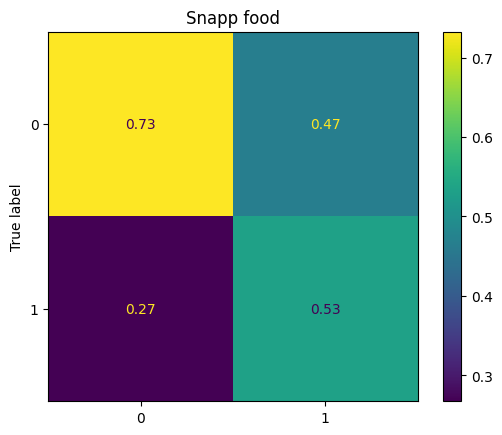

In [29]:
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#y_pred,y_test=predict(snapp_testloader,model)
#y_pred = [0 if label < 2 else 1 for label in y_pred]
result = confusion_matrix(y_test, targets , normalize='pred' )
disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()
disp.ax_.set_title("Snapp food")
disp.ax_.set_xlabel('')
plt.show()

In [30]:
from sklearn.metrics import classification_report
all_targets, all_predictions=predict(snapp_testloader,model)
all_targets = [0 if label < 2 else 1 for label in all_targets]
print("The model classification report on test data is as followed:")
print(classification_report(all_targets, all_predictions))

val:   0%|          | 0/219 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The model classification report on test data is as followed:
              precision    recall  f1-score   support

           0       0.18      0.73      0.29       871
           1       0.93      0.53      0.68      6129

    accuracy                           0.56      7000
   macro avg       0.56      0.63      0.49      7000
weighted avg       0.84      0.56      0.63      7000

